<a href="https://colab.research.google.com/github/Sagnikabhol/Image_classification/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#step 1: Install TensorFlow Datasets
#!pip install tensorflow-datasets

In [ ]:
#STEP 2: Import Required Libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#STEP 3: Load the Food-101 Dataset
(ds_train, ds_test), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.6HX6GU_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.6HX6GU_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
#STEP 4: View Dataset Information
print("Total Classes:", ds_info.features['label'].num_classes)
print("Sample Classes:", ds_info.features['label'].names[:10])

Total Classes: 101
Sample Classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [ ]:
#STEP 5: Process the Image
IMG_SIZE = 224
BATCH_SIZE = 32
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

#Apply Processing to the Datasets - Moved outside the function
ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

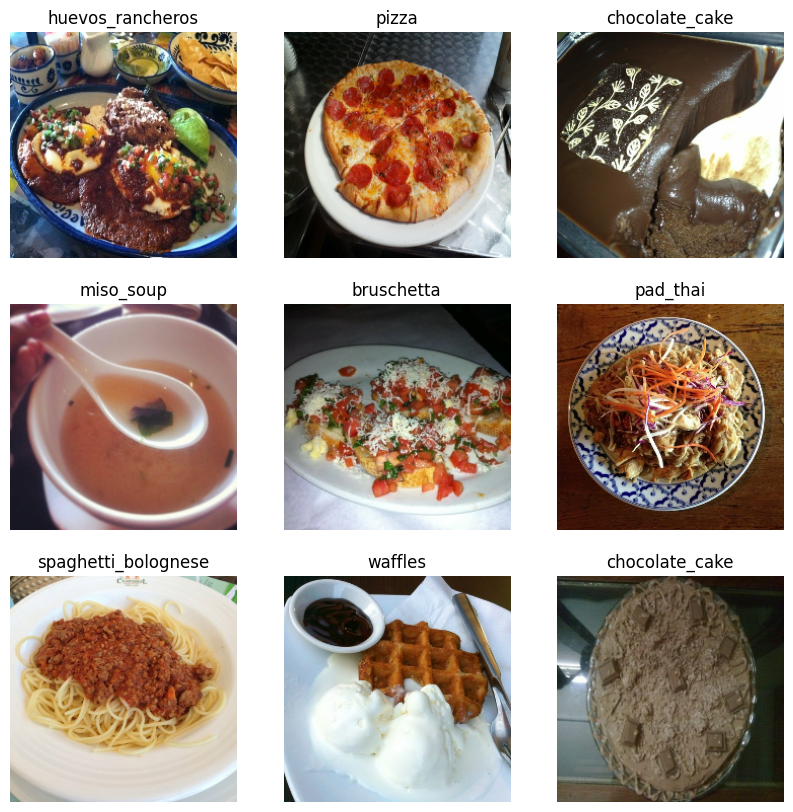

In [ ]:
#step 6 : Visualize Images
for images, labels in ds_train.take(1):
  plt.figure(figsize=(10, 10))
  for i in range(min(9, len(images))):  # Ensure not to exceed the number of images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    # The original code passed the entire labels array to int2str.
    # This has been corrected to pass individual label values.
    label = ds_info.features['label'].int2str(labels.numpy()[i])
    plt.title(label)
    plt.axis("off")
plt.show()
plt.show()

In [ ]:
#STEP 7 : Build the CNN Model(Transfer Learning)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax') # Changed the output layer to have 101 units with softmax
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#STEP 8:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#step-9:train the model
history = model.fit(ds_train, epochs=5, validation_data=ds_test)

In [ ]:
#STEP 10: Evaluate the Model
loss, accuracy = model.evaluate(ds_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

790/790 ━━━━━━━━━━━━━━━━━━━━ 1018s 1s/step - accuracy: 0.0078 - loss: 5.0782
Test Accuracy: 0.84%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


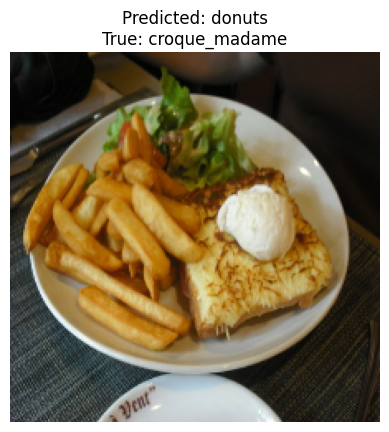

In [ ]:
#STEP 11 : Make Predictions and show results
class_names = ds_info.features['label'].names
for images, labels in ds_test.take(1):
  image = images[0]
  true_label = class_names[labels[0].numpy()]

  image = tf.expand_dims(image, axis=0)
  predictions = model.predict(image)
  predicted_label = class_names[np.argmax(predictions)]

  # Squeeze the image to remove the extra dimension
  plt.imshow(image.numpy().squeeze(0))  # Corrected line
  plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
  plt.axis("off")
  plt.show()

In [ ]:
#step 12: save the trained model
model.save("food101_model.h5")
